# Prévision du Chiffre d'Affaires Annuel (LSTM)
**Dataset**: `BI_QUITTANCIER.csv` — Le chiffre d'affaires annuel (CA) est la somme de la colonne `PRIME_TOTAL` par année.

**Objectif**: Construire un pipeline propre, causal et prêt à l'emploi qui prédit le CA de l'année suivante.

Ce notebook contient :
- Préparation du CA annuel
- Construction du dataset supervisé (lags CA_t-1, CA_t-2)
- Split temporel strict
- Normalisation causale (fit sur train seulement)
- Modèle LSTM léger avec régularisation
- Évaluation et visualisation
- Prédiction du CA de l'année suivante

**Remarque**: placez `BI_QUITTANCIER.csv` dans le même dossier que ce notebook avant exécution.


In [54]:
# 1. Importations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

pd.set_option('display.max_columns', None)

# Chargement robuste des données
PATH = 'BI_QUITTANCIER.csv'  # Assurez-vous que le fichier est dans le même dossier

if not os.path.exists(PATH):
    raise FileNotFoundError(f"Fichier introuvable: {PATH}\nDossier courant: {os.getcwd()}")

def detect_separator(path, sample_lines=8, candidates=(',', ';', '\t', '|'), encodings=('utf-8', 'latin-1')):
    """Détecte le séparateur le plus probable en comptant les occurrences dans les premières lignes."""
    best = (',', 'utf-8')
    best_count = -1
    sample_preview = None
    for enc in encodings:
        try:
            with open(path, 'r', encoding=enc, errors='ignore') as f:
                lines = [f.readline() for _ in range(sample_lines)]
            sample = ''.join(lines)
            sample_preview = lines
            counts = {sep: sample.count(sep) for sep in candidates}
            sep = max(counts, key=counts.get)
            if counts[sep] > best_count:
                best = (sep, enc)
                best_count = counts[sep]
        except Exception:
            continue
    return best + (sample_preview,)

sep_detected, enc_detected, preview = detect_separator(PATH)
print(f"Séparateur détecté: '{sep_detected}' avec encodage '{enc_detected}'")

read_attempts = [
    (sep_detected, enc_detected),
    (sep_detected, 'utf-8'),
    (sep_detected, 'latin-1'),
    (',', 'utf-8'),
    (';', 'utf-8'),
    ('\t', 'utf-8'),
]

df = None
last_error = None
for sep, enc in read_attempts:
    try:
        df = pd.read_csv(PATH, sep=sep, encoding=enc, on_bad_lines='skip', low_memory=False)
        if df.shape[1] < 2:
            raise ValueError(f"Parsing douteux avec sep='{sep}' enc='{enc}' -> {df.shape[1]} colonne(s)")
        print(f"✅ Fichier chargé avec sep='{sep}' enc='{enc}' => shape={df.shape}")
        break
    except Exception as e:
        last_error = e
        continue

if df is None:
    # Diagnostic : afficher les premières lignes lues avec l'encodage détecté
    print("❌ Impossible de parser correctement le CSV. Aperçu des premières lignes:")
    if preview:
        for i, line in enumerate(preview, 1):
            print(f"Ligne {i}: {line[:120]}")
    raise RuntimeError(f"Échec chargement du fichier: {last_error}")

print('Dimensions :', df.shape)
df.head()


Séparateur détecté: ';' avec encodage 'utf-8'
✅ Fichier chargé avec sep=';' enc='utf-8' => shape=(123739, 39)
Dimensions : (123739, 39)


,CODE_COMPAGNIE,CODE_AGENCE,TYPE_AGENCE,CODE_APPORTEUR,NOM_APPORTEUR,CODE_APPORTEUR_2,CODE_BRANCHE,CODE_SOUS_BRANCHE,NUMERO_POLICE,NUM_AVNT_COURS,RANG,CODE_AVENANT,NUMERO_QUITTANCE,TYPE_QUITTANCE,MOIS_ECRITURE,MOIS,ANNEE,ETAT_QUITTANCE,DATE_MVT_DU,DATE_MVT_AU,CODE_COASSURANCE,TYPE_COASSURANCE,CODE_RENOUVELLEMENT,CODE_FRACTIONNEMENT,CODE_CLIENT,NOM_CLIENT,TYPE_CLIENT,VILLE_CLIENT,CODE_ASSURE,NOM_ASSURE,TYPE_ASSURE,VILLE_ASSURE,CODE_GARANTIE,CAPITAL,PRIME,FRAIS,TAXE,COMMISSION,PRIME_TOTAL
0,﻿3,1,Succursale,1.0,AGENCE CENTRALE,1.0,9000,9104,1009104180059,0,0,0,120180400402,C,42018,4,2018,1,2018-05-24 00:00:00.000,2019-05-23 00:00:00.000,N,NaN,2 - FermeSansTerme,0,14,ZOGBELEMOU TOGBA,PERS,Conakry,14,ZOGBELEMOU TOGBA,PERS,Conakry,1,0,923910,15000.0,112669.20,0.0,"1051579,2"
1,3,1,Succursale,1.0,AGENCE CENTRALE,1.0,5000,5290,1005290220010,0,0,0,120220201270,C,22022,2,2022,1,2022-02-25 00:00:00.000,2023-02-24 00:00:00.000,N,NaN,2 - FermeSansTerme,0,14,ZOGBELEMOU TOGBA,PERS,Conakry,14,ZOGBELEMOU TOGBA,PERS,Conakry,1,0,695691,50000.0,79397.00,0.0,825088
2,3,1,Succursale,1.0,AGENCE CENTRALE,1.0,5000,5290,1005290220010,1,0,30,120230201509,C,22023,2,2023,1,2023-02-25 00:00:00.000,2024-02-24 00:00:00.000,N,NaN,2 - FermeSansTerme,0,14,ZOGBELEMOU TOGBA,PERS,Conakry,14,ZOGBELEMOU TOGBA,PERS,Conakry,1,0,347658,25000.0,39672.00,0.0,412330
3,3,516,NaN,516.0,BUREAU DIRECT SIEGE,516.0,5000,5101,5165101190106,0,0,0,120190600395,C,62019,6,2019,1,2019-06-18 00:00:00.000,2020-06-17 00:00:00.000,N,NaN,2 - FermeSansTerme,0,15,BIAYE MAMADOU YAYA,PERS,Conakry,15,BIAYE MAMADOU YAYA,PERS,Conakry,1,0,"420816,28",25000.0,49914.28,0.0,"495730,56"
4,3,1,Succursale,1.0,AGENCE CENTRALE,1.0,5000,5101,1005101170006,0,0,0,120170700008,C,72017,7,2017,1,2017-10-11 00:00:00.000,2018-10-10 00:00:00.000,N,NaN,2 - FermeSansTerme,0,1763,SOCIETE GUINEENENE MULTISERVICES,PERS,Conakry,1763,SOCIETE GUINEENENE MULTISERVICES,PERS,Conakry,1,0,"495816,28",25000.0,58914.28,0.0,"579730,56"


In [ ]:
# 2. Récupération de l'année (17ème colonne du fichier)
# Le fichier comporte déjà la colonne ANNEE en 17ème position (index 16)
YEAR_COL_IDX = 16  # 0-based index

# Extraire la colonne année depuis la position
year_series = pd.to_numeric(df.iloc[:, YEAR_COL_IDX], errors='coerce')

# Ajouter/écraser la colonne ANNEE
df['ANNEE'] = year_series

# Supprimer les lignes sans année
df = df.dropna(subset=['ANNEE'])

# Vérifier la présence de PRIME_TOTAL
target_col = 'PRIME_TOTAL'
assert target_col in df.columns, f"Colonne {target_col} introuvable. Vérifiez le nom."

# Conversion de la target en numérique (remplacer les virgules décimales)
df[target_col] = pd.to_numeric(df[target_col].astype(str).str.replace(',', '.', regex=False), errors='coerce')

# Nettoyer années et cible
mask_valid = df['ANNEE'].notna() & df[target_col].notna()
df = df[mask_valid].copy()

# Trier chronologiquement sur ANNEE
df = df.sort_values('ANNEE').reset_index(drop=True)
print('Années dans le dataset:', int(df['ANNEE'].min()), '->', int(df['ANNEE'].max()))

# Aperçu
print(df[['ANNEE', target_col]].head())


Années dans le dataset: 2017 -> 2025
   ANNEE  PRIME_TOTAL
0   2017    616193.00
1   2017    579730.56
2   2017    206430.09
3   2017    495730.56
4   2017    206430.09


In [ ]:
# 2b. Vérification et traitement des valeurs manquantes / outliers

print("=== Vérification des valeurs manquantes ===")
missing_counts = df.isna().sum()
print(missing_counts[missing_counts > 0])

# Supprimer les lignes sans année ou sans target
before_drop = len(df)
df = df.dropna(subset=['ANNEE', target_col])
print(f"Lignes supprimées (ANNEE/PRIME_TOTAL manquantes): {before_drop - len(df)}")

# Outliers sur PRIME_TOTAL (capping IQR)
q1 = df[target_col].quantile(0.25)
q3 = df[target_col].quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

before_clip = df[target_col].copy()
df[target_col] = df[target_col].clip(lower, upper)
clipped = (before_clip != df[target_col]).sum()
print(f"Outliers capés sur {target_col}: {clipped}")
print(f"Bornes utilisées: lower={lower:.2f}, upper={upper:.2f}")

print("\nÉchantillon après nettoyage:")
print(df[[target_col]].describe())


=== Vérification des valeurs manquantes ===
TYPE_AGENCE         100636
CODE_APPORTEUR           4
NOM_APPORTEUR            4
CODE_APPORTEUR_2      4122
TYPE_COASSURANCE    123718
NOM_CLIENT              22
TYPE_CLIENT              1
VILLE_CLIENT         22727
NOM_ASSURE              74
TYPE_ASSURE              1
VILLE_ASSURE         22810
dtype: int64
Lignes supprimées (ANNEE/PRIME_TOTAL manquantes): 0
Outliers capés sur PRIME_TOTAL: 13530
Bornes utilisées: lower=-468803.17, upper=1297237.82

Échantillon après nettoyage:
        PRIME_TOTAL
count  1.237390e+05
mean   4.811188e+05
std    3.718708e+05
min   -4.688032e+05
25%    1.934622e+05
50%    4.585725e+05
75%    6.349724e+05
max    1.297238e+06


In [ ]:
# 3. Calcul du CA annuel (somme de PRIME_TOTAL par année)
df_CA = df.groupby('ANNEE', as_index=False)[target_col].sum()
df_CA = df_CA.rename(columns={target_col:'CA'})
print('Nombre d\'années:', len(df_CA))
df_CA


Nombre d'années: 9


,ANNEE,CA
0,2017,4.680714e+08
1,2018,2.918219e+09
2,2019,5.383569e+09
3,2020,5.584026e+09
4,2021,7.021173e+09
5,2022,8.080629e+09
6,2023,9.900484e+09
7,2024,1.189484e+10
8,2025,8.282146e+09


In [ ]:
# 4. Création des lags (CA_t-1, CA_t-2)
df_CA['CA_t-1'] = df_CA['CA'].shift(1)
df_CA['CA_t-2'] = df_CA['CA'].shift(2)

# Supprimer années incomplètes (les premières lignes avec NaN)
df_CA = df_CA.dropna().reset_index(drop=True)
print('Après création des lags, années disponibles:', len(df_CA))
df_CA


Après création des lags, années disponibles: 7


,ANNEE,CA,CA_t-1,CA_t-2
0,2019,5.383569e+09,2.918219e+09,4.680714e+08
1,2020,5.584026e+09,5.383569e+09,2.918219e+09
2,2021,7.021173e+09,5.584026e+09,5.383569e+09
3,2022,8.080629e+09,7.021173e+09,5.584026e+09
4,2023,9.900484e+09,8.080629e+09,7.021173e+09
5,2024,1.189484e+10,9.900484e+09,8.080629e+09
6,2025,8.282146e+09,1.189484e+10,9.900484e+09


In [ ]:
# 5. Split temporel strict (70% train, 20% val, 10% test) avec minimums
values = df_CA[['CA','CA_t-1','CA_t-2']].values
n = len(values)

train_size = max(3, int(n * 0.6))
val_size   = max(2, int(n * 0.2))
test_size  = n - train_size - val_size
if test_size < 1:
    test_size = 1
    val_size  = n - train_size - test_size
    if val_size < 2:
        val_size = 2
        train_size = n - val_size - test_size

train_end = train_size
val_end   = train_size + val_size

train = values[:train_end]
val   = values[train_end:val_end]
test  = values[val_end:]

print('Tailles -> total:', n, 'train:', len(train), 'val:', len(val), 'test:', len(test))

# Safety checks
assert len(train) > 0 and len(val) > 1 and len(test) > 0, "Taille de split incorrecte. Trop peu d'années."


Tailles -> total: 7 train: 4 val: 2 test: 1


In [ ]:
# 6. Normalisation des FEATURES uniquement (pas de scaling de la target)
# X = [CA_t-1, CA_t-2], y = CA
train_X_raw = train[:, 1:]
val_X_raw   = val[:, 1:]
test_X_raw  = test[:, 1:]

y_train = train[:, 0]
y_val   = val[:, 0]
y_test  = test[:, 0]

scaler_X = MinMaxScaler()
scaler_X.fit(train_X_raw)

X_train_scaled = scaler_X.transform(train_X_raw).reshape((train_X_raw.shape[0], train_X_raw.shape[1], 1))
X_val_scaled   = scaler_X.transform(val_X_raw).reshape((val_X_raw.shape[0],   val_X_raw.shape[1],   1))
X_test_scaled  = scaler_X.transform(test_X_raw).reshape((test_X_raw.shape[0], test_X_raw.shape[1], 1))

X_train, X_val, X_test = X_train_scaled, X_val_scaled, X_test_scaled

print('Shapes -> X_train:', X_train.shape, 'y_train:', y_train.shape)
print('                val :', X_val.shape,   'y_val  :', y_val.shape)
print('                test:', X_test.shape,  'y_test :', y_test.shape)


Shapes -> X_train: (4, 2, 1) y_train: (4,)
                val : (2, 2, 1) y_val  : (2,)
                test: (1, 2, 1) y_test : (1,)


In [61]:
# 7. Définir l'architecture LSTM
tf.random.set_seed(42)
model = Sequential([
    LSTM(32, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')
model.summary()


C:\Users\seift\Documents\LSTM\tf-env\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 32)                  │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,897 (19.13 KB)

 Trainable params: 4,897 (19.13 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
# 8. Entraînement (une seule fois)
es = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=400,
    batch_size=4,
    callbacks=[es, rlp],
    verbose=1,
    shuffle=False
)


Epoch 1/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 43689397994888626176.0000 - val_loss: 119753405696246284288.0000 - learning_rate: 0.0010
Epoch 2/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 43689397994888626176.0000 - val_loss: 119753405696246284288.0000 - learning_rate: 0.0010
Epoch 3/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - loss: 43689397994888626176.0000 - val_loss: 119753405696246284288.0000 - learning_rate: 0.0010
Epoch 4/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - loss: 43689397994888626176.0000 - val_loss: 119753405696246284288.0000 - learning_rate: 0.0010
Epoch 5/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - loss: 43689397994888626176.0000 - val_loss: 119753405696246284288.0000 - learning_rate: 0.0010
Epoch 6/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - loss: 43689397994888626176.0000 - val_loss: 119753405696246284288.0000 - learning_rate: 0.0010
Epoch 7/400
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 43689397994888626176.0000 - val_loss: 119753405696246284

In [64]:
# 9. Évaluation - métriques sur la cible NON scalée
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


def eval_and_print(X, y, name='Set'):
    y_pred = model.predict(X).reshape(-1)
    y_true = y

    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

    print(f"\n📌 {name}")
    print(f"MSE  : {mse:.6f}")
    print(f"MAE  : {mae:.6f}")
    print(f"R²   : {r2:.6f}")
    print(f"MAPE : {mape:.2f}%")

    return y_true, y_pred

val_true, val_pred = eval_and_print(X_val, y_val, 'Validation')
test_true, test_pred = eval_and_print(X_test, y_test, 'Test')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step

📌 Validation
MSE  : 119753408892387557376.000000
MAE  : 10897662318.603203
R²   : -119.432058
MAPE : 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

📌 Test
MSE  : 68593945999915302912.000000
MAE  : 8282146219.423761
R²   : nan
MAPE : 100.00%


C:\Users\seift\Documents\LSTM\tf-env\Lib\site-packages\sklearn\metrics\_regression.py:1283: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


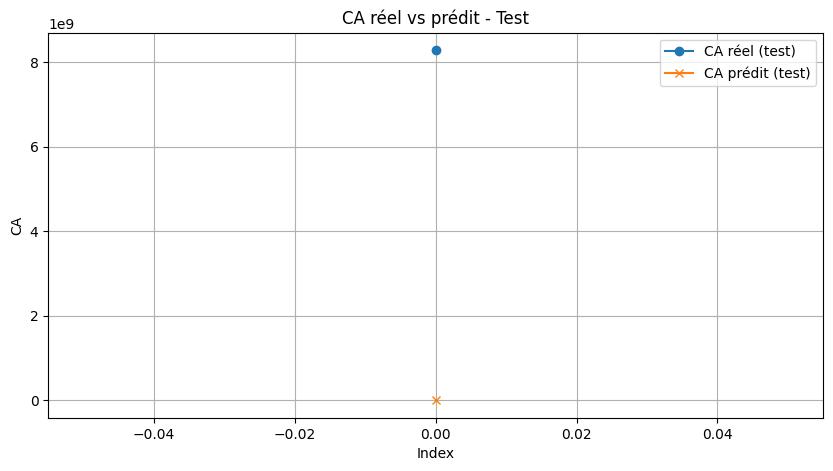

In [65]:
# 10. Visualisation des prédictions (Test)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(test_true, label='CA réel (test)', marker='o')
plt.plot(test_pred, label='CA prédit (test)', marker='x')
plt.title('CA réel vs prédit - Test')
plt.xlabel('Index')
plt.ylabel('CA')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# 11. Prédiction du CA pour l'année suivante
# Construire l'entrée à partir des deux dernières années connues
last_row = df_CA[['CA_t-1','CA_t-2']].iloc[-1].values  # [CA_{t-1}, CA_{t-2}]
input_scaled = scaler_X.transform(last_row.reshape(1, -1))
X_future = input_scaled.reshape(1, 2, 1)

future_CA = model.predict(X_future).reshape(-1)[0]
print('\n📌 Prévision du CA pour l\'année suivante :', round(float(future_CA),2))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

📌 Prévision du CA pour l'année suivante : 323441704826.81


In [43]:
# 12. Sauvegarder modèle & scaler
model.save('lstm_ca_model.h5')
import joblib
joblib.dump(scaler, 'scaler_ca.save')
print('Modèle et scaler sauvegardés : lstm_ca_model.h5, scaler_ca.save')


Modèle et scaler sauvegardés : lstm_ca_model.h5, scaler_ca.save
